Glad to finish my first neural network! Thanks to all kindly people who shared their kernal and write guidance for beginners. This kernal is written in Pytorch, and ResNet50 of fastai models is used to build siamese network.
Special thanks to [this article](https://www.kaggle.com/leonbora/kinship-recognition-transfer-learning-vggface). It is the first time for me to see data organized like this, and his kernal gives me an example to deal with them. I copied the data processing code from his kernal , as can be seen in the 4th code block.
Also thanks to [harveyslash](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/tree/master), his code is taught [here](https://www.pytorchtutorial.com/pytorch-one-shot-learning/) in Chinese. By reading his tutorial I have a thorough understanding about how to write pytorch code, and the basic use of dataloader and network. After finish this work the first time, I accidently found that most of his code is similar to the [official tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar). Though I ran this tutorial a month ago, I didn't learn a lot from it.
Finally, thanks to kaggle for offering this platform and 16G GPU for us. I really appreciate it. 
If you are also beginner as I do, just get your hands dirty. Once finish a competition by yourself, you will learn a lot from it.
Best wishes to you!

In [1]:
#some of blocks below are not used.

# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys

from glob import glob
from PIL import Image

In [2]:
np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE=64
NUMBER_EPOCHS=100
IMG_SIZE=100

In [3]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()


In [5]:
#F09xx are used for validation.
val_famillies = "F09"

#An example of data:"../input/train/F00002/MID1/P0001_face1.jpg"
all_images = glob("../input/train/*/*/*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)#Put the link of each picture under the key word of a person such as "F0002/MID1"
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
relationships = pd.read_csv("../input/train_relationships.csv")
relationships = list(zip(relationships.p1.values, relationships.p2.values))#For a List like[p1 p2], zip can return a result like [(p1[0],p2[0]),(p1[1],p2[1]),...]
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]#filter unused relationships

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(train))    
print("Total val pairs:", len(val))    

NameError: name 'defaultdict' is not defined

In [5]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.relationships = relationships #choose either train or val dataset to use
        self.transform = transform
        
    def __getitem__(self,index):
        img0_info = self.relationships[index][0]#for each relationship in train_relationships.csv, the first img comes from first row, and the second is either specially choosed related person or randomly choosed non-related person
        img0_path = glob("../input/train/"+img0_info+"/*.jpg")
        img0_path = random.choice(img0_path)
        
        cand_relationships = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info]#found all candidates related to person in img0
        if cand_relationships==[]:#in case no relationship is mensioned. But it is useless here because I choose the first person line by line.
            should_get_same_class = 0
        else:
            should_get_same_class = random.randint(0,1) 

        if should_get_same_class==1:#1 means related, and 0 means non-related.
            img1_info = random.choice(cand_relationships)#choose the second person from related relationships
            if img1_info[0]!=img0_info:
                img1_info=img1_info[0]
            else:
                img1_info=img1_info[1]
            img1_path = glob("../input/train/"+img1_info+"/*.jpg")#randomly choose a img of this person
            img1_path = random.choice(img1_path)
        else:#0 means non-related
            randChoose = True#in case the chosen person is related to first person
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]
                img1_info = img1_path.split("/")[-3] + "/" + img1_path.split("/")[-2]
                randChoose = False
                for x in cand_relationships:#if so, randomly choose another person
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break
                    
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        
        if self.transform is not None:#I think the transform is essential if you want to use GPU, because you have to trans data to tensor first.
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , should_get_same_class #the returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
    
    def __len__(self):
        return len(self.relationships)#essential for choose the num of data in one epoch

In [6]:
folder_dataset = dset.ImageFolder(root='../input/train')

trainset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=train,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=BATCH_SIZE)
valset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=val,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)


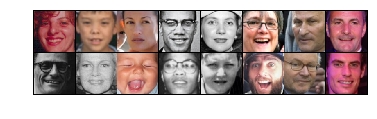

[0 0 1 1 1 0 1 1]


In [7]:
#only for visualize data in dataloader, it won't matters if you delete this block.
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [8]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #self.cnn1 = models.resnet50(pretrained=True)#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        #self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)


    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

Epoch： 0  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


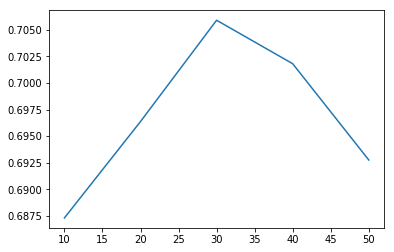

Epoch： 1  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


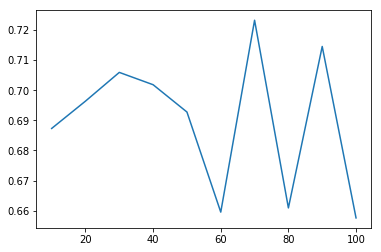

Epoch： 2  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


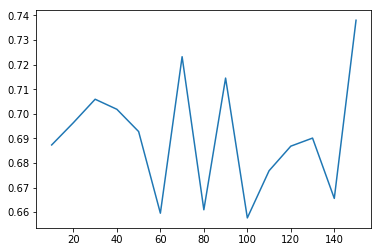

Epoch： 3  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


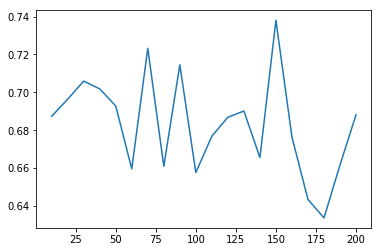

Epoch： 4  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


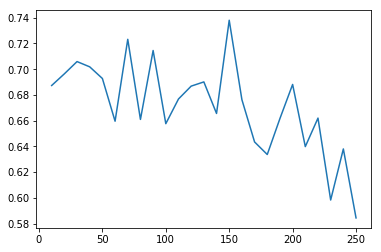

Epoch： 5  start.
Accuracy of the network on the 296 val pairs in F09 : 65 %


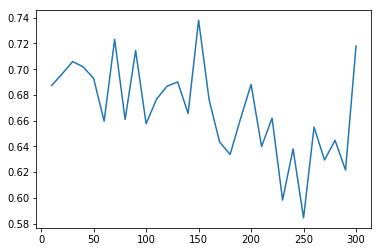

Epoch： 6  start.
Accuracy of the network on the 296 val pairs in F09 : 63 %


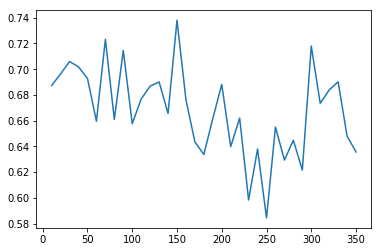

Epoch： 7  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


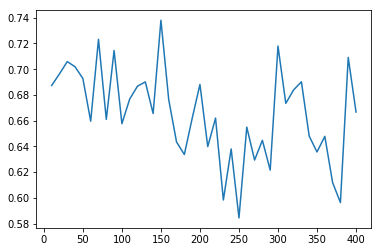

Epoch： 8  start.
Accuracy of the network on the 296 val pairs in F09 : 62 %


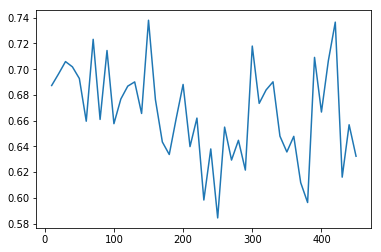

Epoch： 9  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


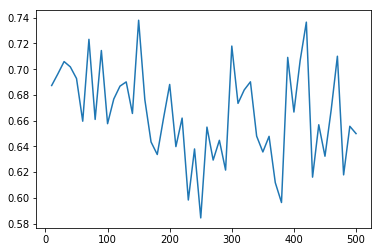

Epoch： 10  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


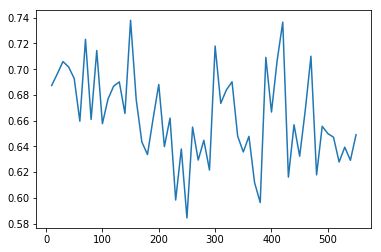

Epoch： 11  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


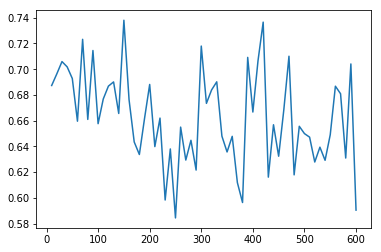

Epoch： 12  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


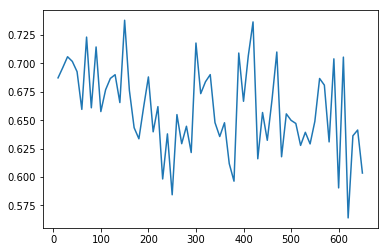

Epoch： 13  start.
Accuracy of the network on the 296 val pairs in F09 : 64 %


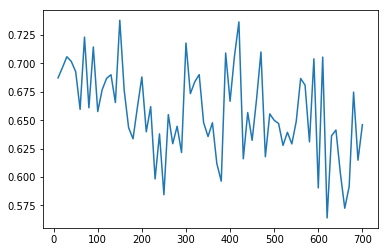

Epoch： 14  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


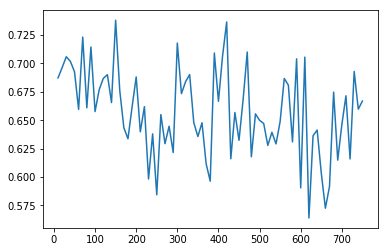

Epoch： 15  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


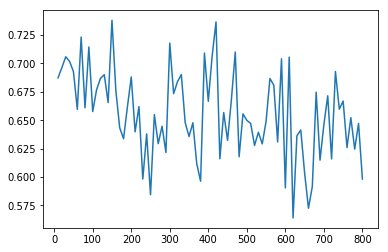

Epoch： 16  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


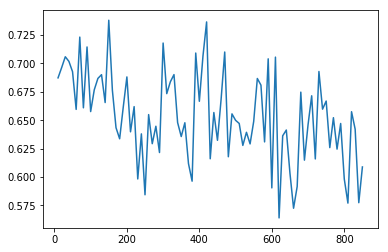

Epoch： 17  start.
Accuracy of the network on the 296 val pairs in F09 : 64 %


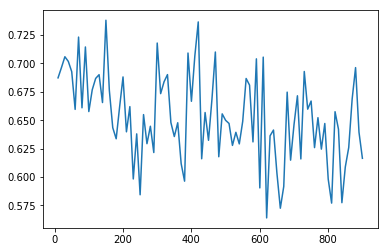

Epoch： 18  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


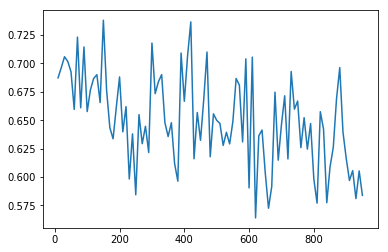

Epoch： 19  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


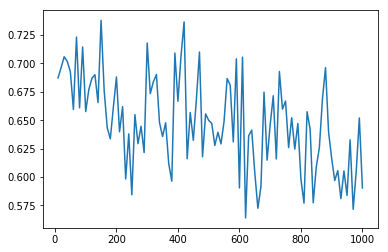

Epoch： 20  start.
Accuracy of the network on the 296 val pairs in F09 : 64 %


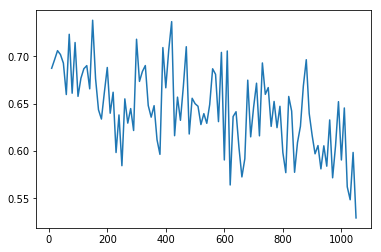

Epoch： 21  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


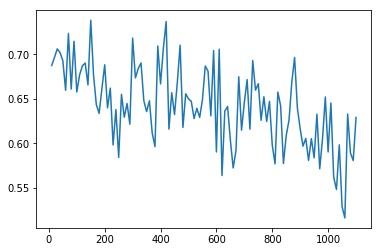

Epoch： 22  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


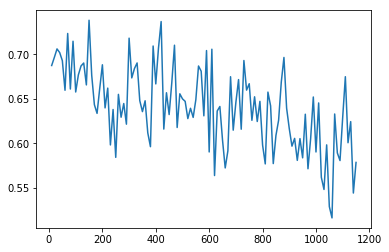

Epoch： 23  start.
Accuracy of the network on the 296 val pairs in F09 : 63 %


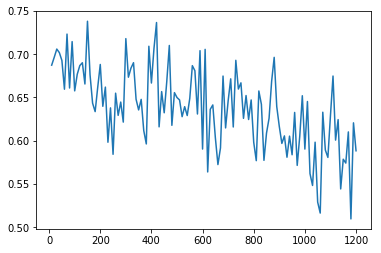

Epoch： 24  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


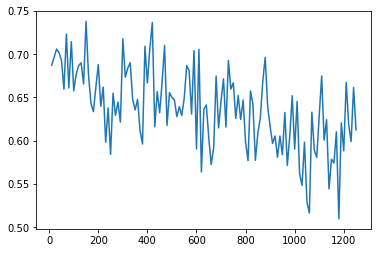

Epoch： 25  start.
Accuracy of the network on the 296 val pairs in F09 : 63 %


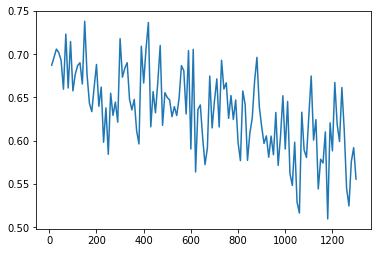

Epoch： 26  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


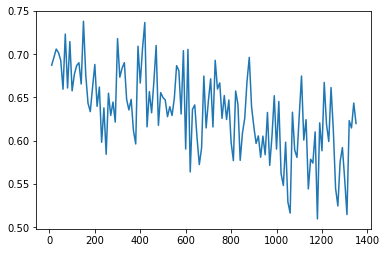

Epoch： 27  start.
Accuracy of the network on the 296 val pairs in F09 : 62 %


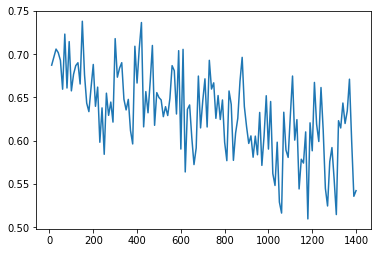

Epoch： 28  start.
Accuracy of the network on the 296 val pairs in F09 : 63 %


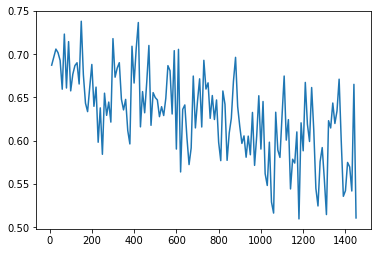

Epoch： 29  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


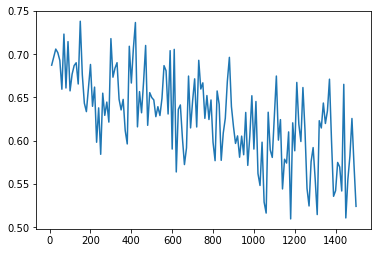

Epoch： 30  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


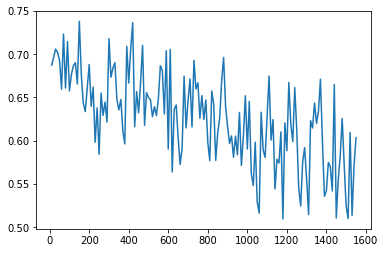

Epoch： 31  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


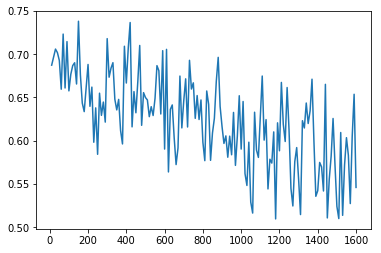

Epoch： 32  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


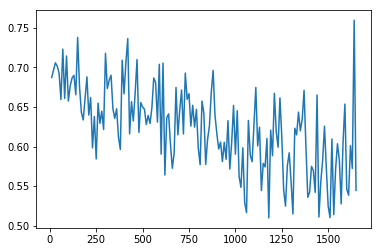

Epoch： 33  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


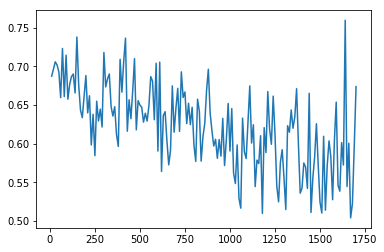

Epoch： 34  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


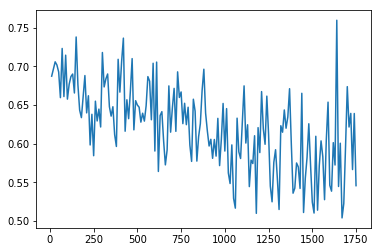

Epoch： 35  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


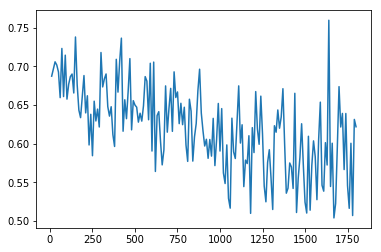

Epoch： 36  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


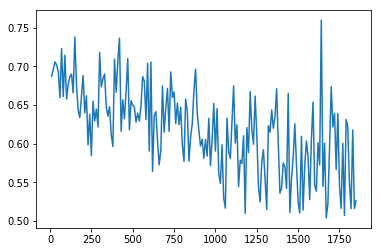

Epoch： 37  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


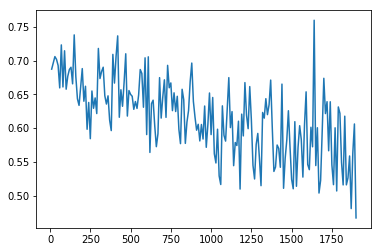

Epoch： 38  start.
Accuracy of the network on the 296 val pairs in F09 : 63 %


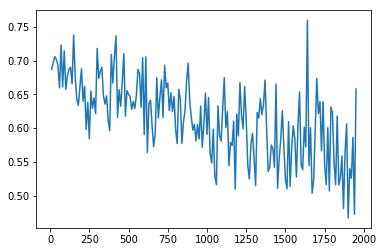

Epoch： 39  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


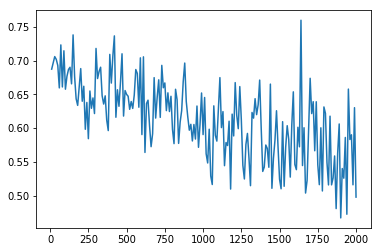

Epoch： 40  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


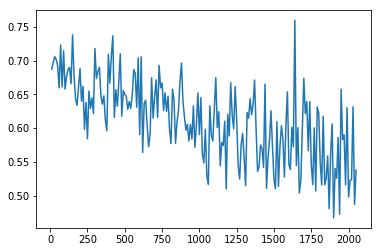

Epoch： 41  start.
Accuracy of the network on the 296 val pairs in F09 : 51 %


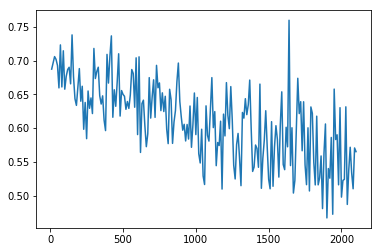

Epoch： 42  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


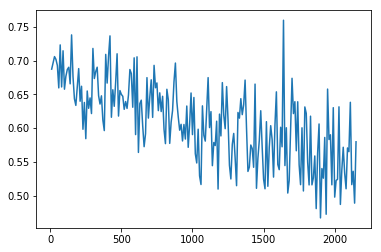

Epoch： 43  start.
Accuracy of the network on the 296 val pairs in F09 : 61 %


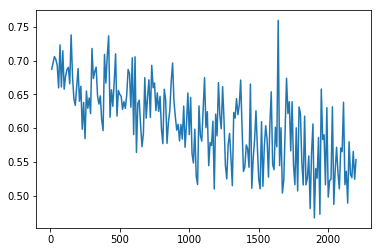

Epoch： 44  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


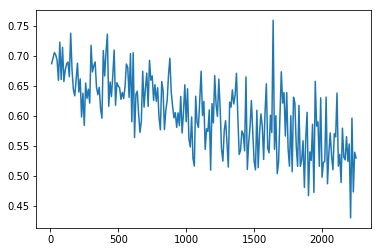

Epoch： 45  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


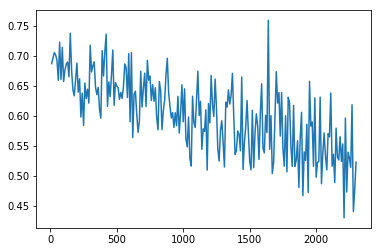

Epoch： 46  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


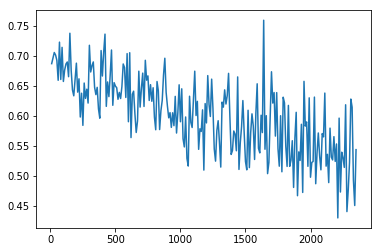

Epoch： 47  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


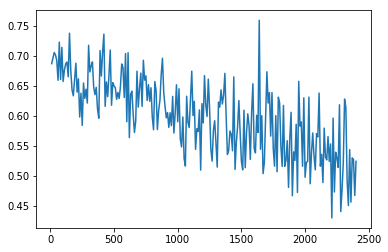

Epoch： 48  start.
Accuracy of the network on the 296 val pairs in F09 : 52 %


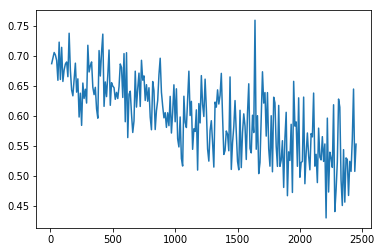

Epoch： 49  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


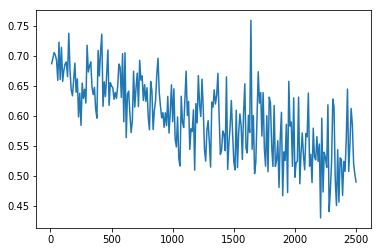

Epoch： 50  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


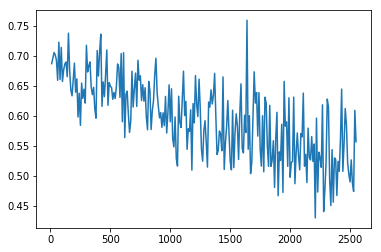

Epoch： 51  start.
Accuracy of the network on the 296 val pairs in F09 : 51 %


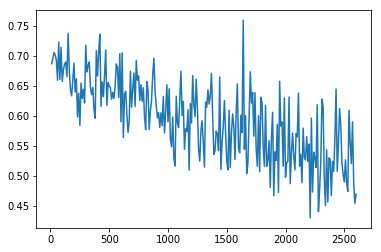

Epoch： 52  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


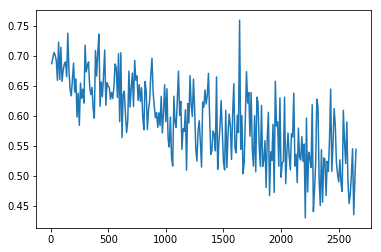

Epoch： 53  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


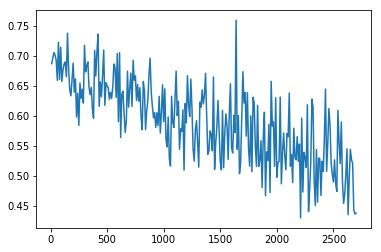

Epoch： 54  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


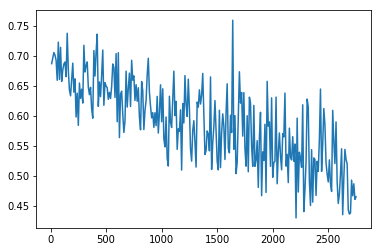

Epoch： 55  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


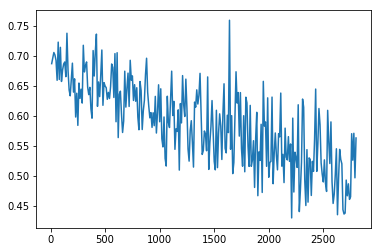

Epoch： 56  start.
Accuracy of the network on the 296 val pairs in F09 : 63 %


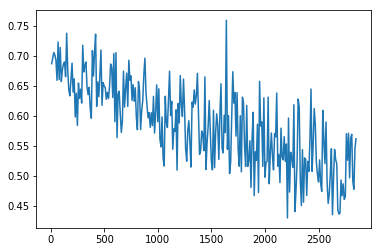

Epoch： 57  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


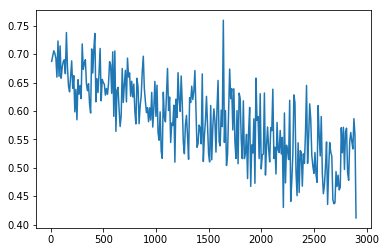

Epoch： 58  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


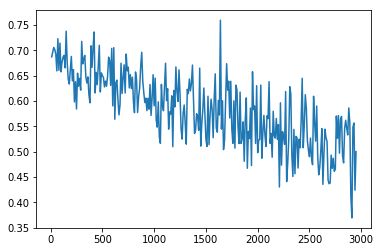

Epoch： 59  start.
Accuracy of the network on the 296 val pairs in F09 : 52 %


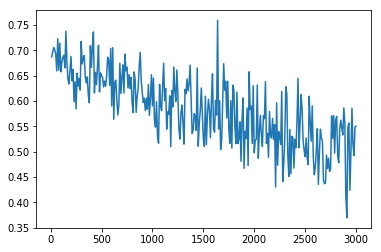

Epoch： 60  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


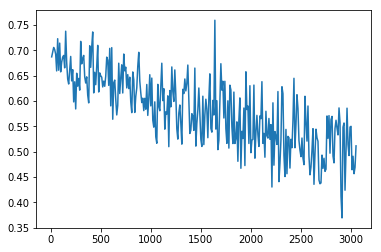

Epoch： 61  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


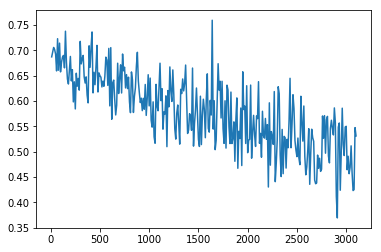

Epoch： 62  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


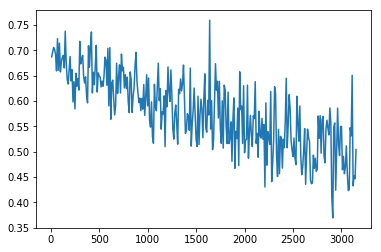

Epoch： 63  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


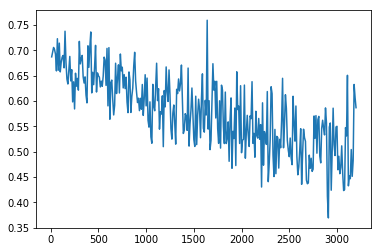

Epoch： 64  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


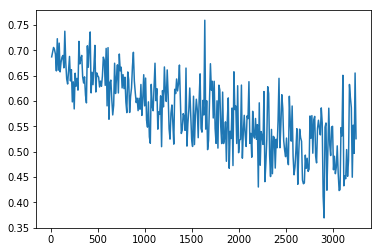

Epoch： 65  start.
Accuracy of the network on the 296 val pairs in F09 : 60 %


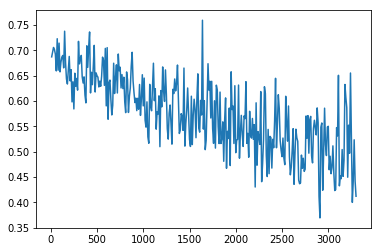

Epoch： 66  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


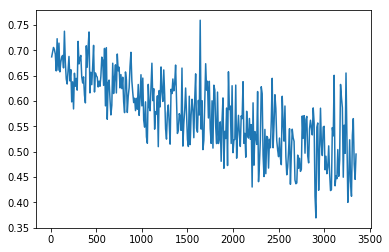

Epoch： 67  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


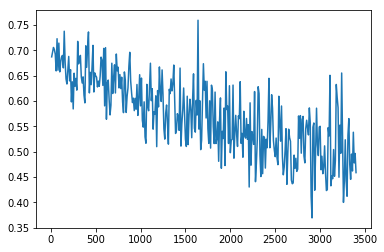

Epoch： 68  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


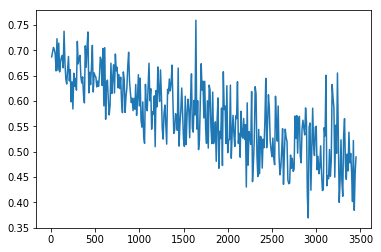

Epoch： 69  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


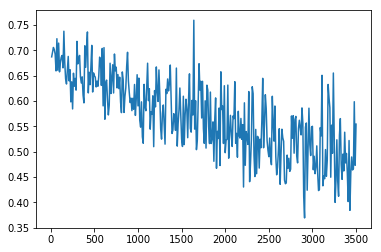

Epoch： 70  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


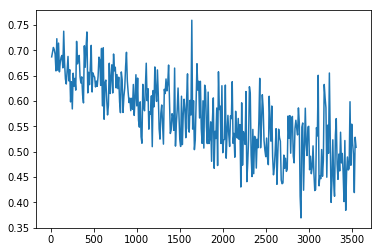

Epoch： 71  start.
Accuracy of the network on the 296 val pairs in F09 : 53 %


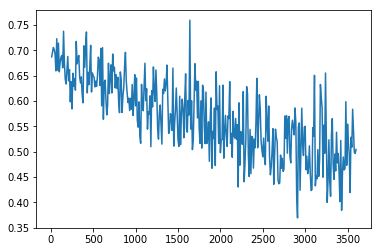

Epoch： 72  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


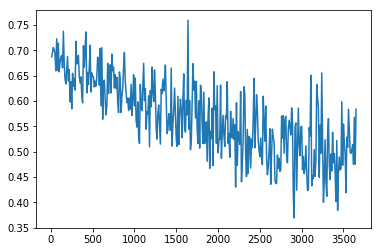

Epoch： 73  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


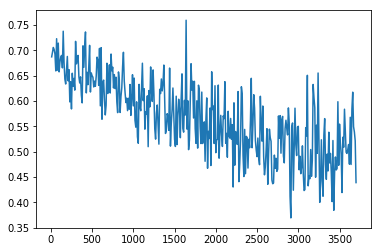

Epoch： 74  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


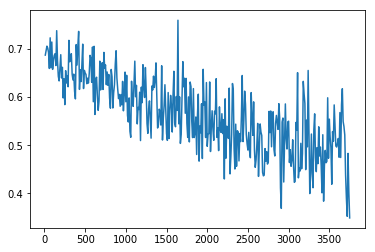

Epoch： 75  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


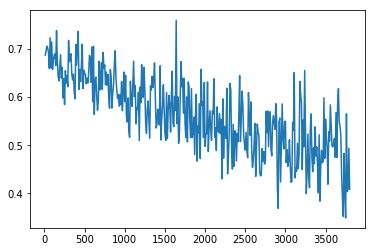

Epoch： 76  start.
Accuracy of the network on the 296 val pairs in F09 : 59 %


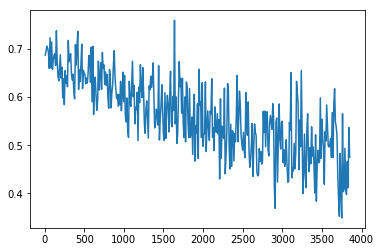

Epoch： 77  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


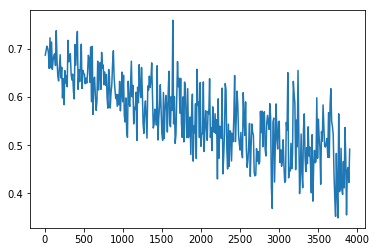

Epoch： 78  start.
Accuracy of the network on the 296 val pairs in F09 : 54 %


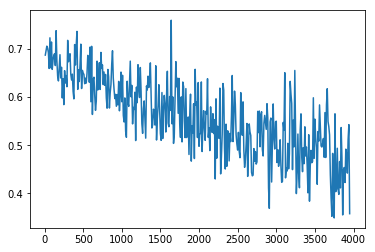

Epoch： 79  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


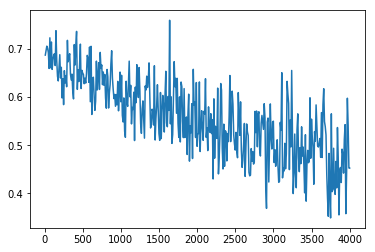

Epoch： 80  start.
Accuracy of the network on the 296 val pairs in F09 : 53 %


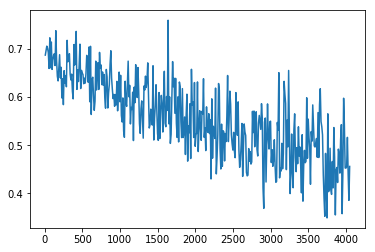

Epoch： 81  start.
Accuracy of the network on the 296 val pairs in F09 : 55 %


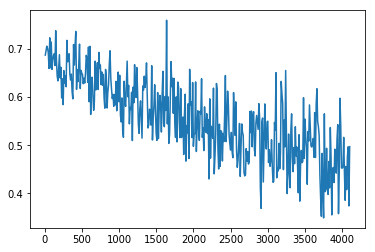

Epoch： 82  start.
Accuracy of the network on the 296 val pairs in F09 : 52 %


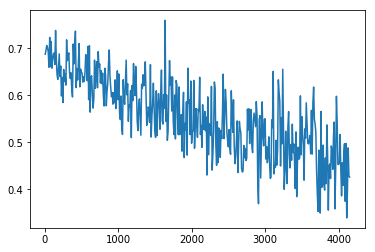

Epoch： 83  start.
Accuracy of the network on the 296 val pairs in F09 : 50 %


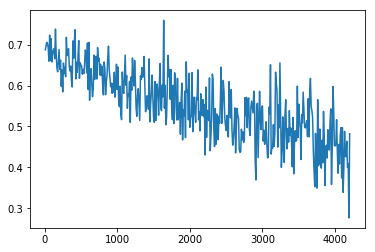

Epoch： 84  start.
Accuracy of the network on the 296 val pairs in F09 : 51 %


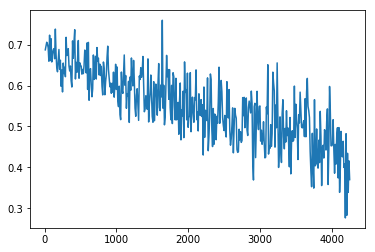

Epoch： 85  start.
Accuracy of the network on the 296 val pairs in F09 : 50 %


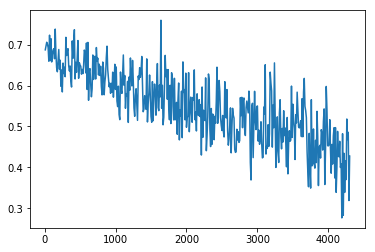

Epoch： 86  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


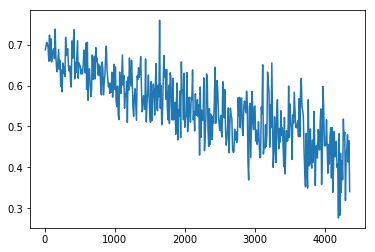

Epoch： 87  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


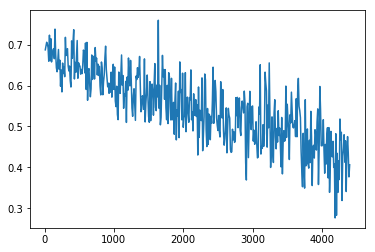

Epoch： 88  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


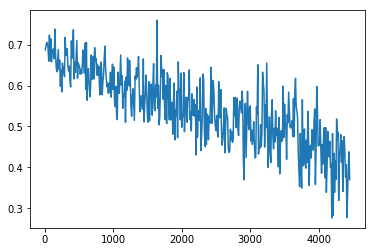

Epoch： 89  start.
Accuracy of the network on the 296 val pairs in F09 : 56 %


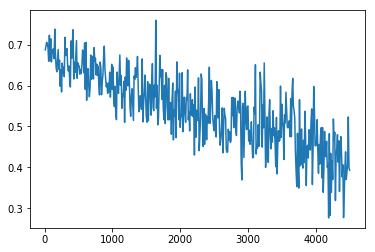

Epoch： 90  start.
Accuracy of the network on the 296 val pairs in F09 : 51 %


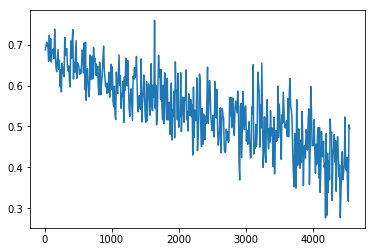

Epoch： 91  start.
Accuracy of the network on the 296 val pairs in F09 : 47 %


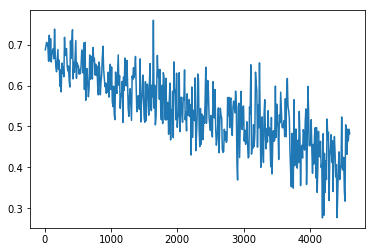

Epoch： 92  start.
Accuracy of the network on the 296 val pairs in F09 : 58 %


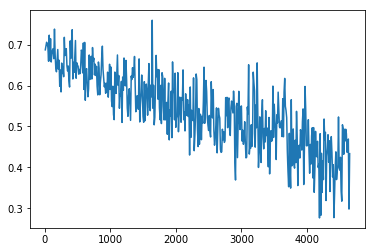

Epoch： 93  start.
Accuracy of the network on the 296 val pairs in F09 : 52 %


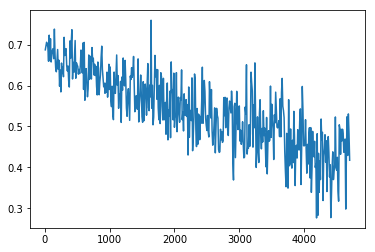

Epoch： 94  start.
Accuracy of the network on the 296 val pairs in F09 : 50 %


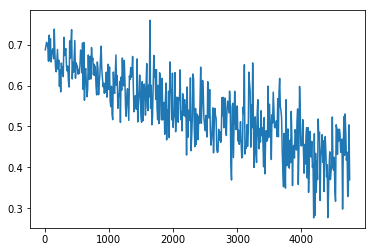

Epoch： 95  start.
Accuracy of the network on the 296 val pairs in F09 : 52 %


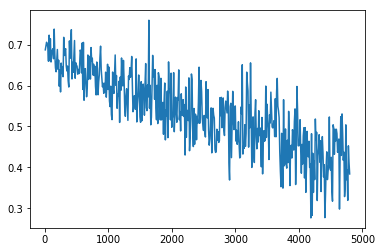

Epoch： 96  start.
Accuracy of the network on the 296 val pairs in F09 : 50 %


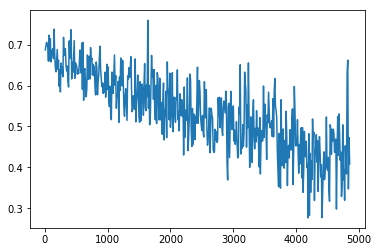

Epoch： 97  start.
Accuracy of the network on the 296 val pairs in F09 : 57 %


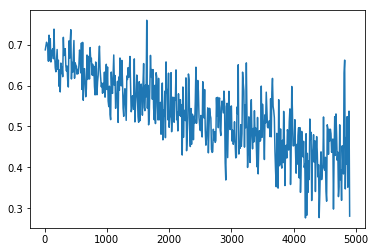

Epoch： 98  start.
Accuracy of the network on the 296 val pairs in F09 : 53 %


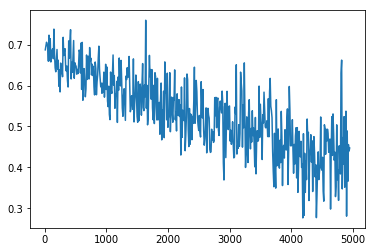

Epoch： 99  start.
Accuracy of the network on the 296 val pairs in F09 : 51 %


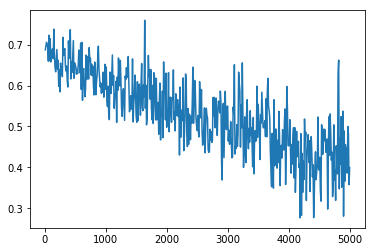

In [9]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val, 'val pairs in',val_famillies, ': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)
    



In [10]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,transform=None):
        self.test_df = pd.read_csv('../input/sample_submission.csv')#pandas用来读取csv文件
        self.transform = transform
        
    def __getitem__(self,index):
        #data in submission.csv:
        #       img_pair               is_related
        #face05508.jpg-face01210.jpg       0
        #face05820.jpg-face03938.jpg       0
        
        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]
        #print(img0_path,'-',img1_path) #reserved to check whether test data is in order.
        
        img0 = Image.open('../input/test/'+img0_path)
        img1 = Image.open('../input/test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1
    
    def __len__(self):
        return len(self.test_df)

In [11]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [12]:
test_df = pd.read_csv('../input/sample_submission.csv')#pandas用来读取csv文件
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer
        
test_df['is_related'] = predictions
test_df.to_csv("submission.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed


,img_pair,is_related
0,face05508.jpg-face01210.jpg,1.0
1,face05750.jpg-face00898.jpg,1.0
2,face05820.jpg-face03938.jpg,1.0
3,face02104.jpg-face01172.jpg,1.0
4,face02428.jpg-face05611.jpg,0.0
5,face01219.jpg-face00274.jpg,0.0
6,face04262.jpg-face00555.jpg,0.0
7,face03697.jpg-face01892.jpg,1.0
8,face03524.jpg-face00319.jpg,1.0
9,face03410.jpg-face05368.jpg,0.0
